In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Load data
DATA_PATH = "/content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/"

df_pca = pd.read_csv(DATA_PATH + 'data_pca30 (1).csv', index_col=0)
X_pca30 = df_pca.values

print(f"Đã load data: {X_pca30.shape}")
print(f"Số mẫu: {X_pca30.shape[0]}, Số features: {X_pca30.shape[1]}")

Đã load data: (801, 30)
Số mẫu: 801, Số features: 30


## Bước 1: Implement K-Means++ từ đầu

K-Means++ cải tiến bước khởi tạo centroids:
1. Chọn điểm đầu tiên ngẫu nhiên làm centroid
2. Với mỗi điểm còn lại, tính khoảng cách đến centroid gần nhất
3. Chọn điểm tiếp theo với xác suất tỷ lệ với bình phương khoảng cách
4. Lặp lại cho đến khi có đủ K centroids

In [48]:
import numpy as np

class KMeansPlusPlus:
    def __init__(self, n_clusters=5, max_iters=300, tol=1e-4, random_state=1):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # --- BƯỚC 1: KHỞI TẠO CENTROIDS (K-MEANS++) ---
        # Chọn tâm đầu tiên ngẫu nhiên
        self.centroids = [X[np.random.randint(n_samples)]]

        for _ in range(1, self.n_clusters):
            # Tính khoảng cách từ mọi điểm đến các centroids hiện có
            # Dùng broadcasting để tính nhanh
            # dist_sq shape: (n_samples, n_current_centroids)
            dist_sq = np.sum((X[:, None, :] - np.array(self.centroids)[None, :, :]) ** 2, axis=2)

            # Lấy khoảng cách gần nhất cho mỗi điểm
            min_dist_sq = np.min(dist_sq, axis=1)

            # Tính xác suất (xử lý chia cho 0 nếu cần, nhưng thường sum > 0)
            probs = min_dist_sq / np.sum(min_dist_sq)

            # Chọn tâm tiếp theo
            next_centroid_idx = np.random.choice(n_samples, p=probs)
            self.centroids.append(X[next_centroid_idx])

        self.centroids = np.array(self.centroids)

        # --- BƯỚC 2: VÒNG LẶP CHÍNH ---
        for i in range(self.max_iters):
            # 2.1. Gán nhãn (Vectorized) -> KHÔNG DÙNG FOR LOOP
            # Tính khoảng cách từ tất cả điểm X đến tất cả Centroids cùng lúc
            # distances shape: (n_samples, n_clusters)
            distances = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)

            # Gán nhãn mới
            new_labels = np.argmin(distances, axis=1)

            # 2.2. Cập nhật tâm (Vectorized)
            new_centroids = np.array([
                X[new_labels == k].mean(axis=0) if np.sum(new_labels == k) > 0 else self.centroids[k]
                for k in range(self.n_clusters)
            ])

            # 2.3. Kiểm tra hội tụ
            shift = np.linalg.norm(self.centroids - new_centroids)
            self.centroids = new_centroids
            self.labels_ = new_labels

            if shift < self.tol:
                print(f"K-Means++ hội tụ tại vòng lặp {i+1}")
                break

        # Tính Inertia cuối cùng
        dists = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
        min_dists_sq = np.min(dists, axis=1) ** 2
        self.inertia_ = np.sum(min_dists_sq)

        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

## Bước 2: Test nhanh với 5 clusters

In [49]:
# Test với 5 clusters
print("Test K-Means++ với 5 clusters:\n")
kmpp_test = KMeansPlusPlus(n_clusters=5, random_state=42)
test_labels = kmpp_test.fit_predict(X_pca30)

# Thống kê
print("\nPhân bố clusters:")
unique, counts = np.unique(test_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(test_labels)*100:.1f}%)")

print(f"\nInertia: {kmpp_test.inertia_:.2f}")

Test K-Means++ với 5 clusters:

K-Means++ hội tụ tại vòng lặp 6

Phân bố clusters:
  Cluster 0: 252 samples (31.5%)
  Cluster 1: 145 samples (18.1%)
  Cluster 2: 75 samples (9.4%)
  Cluster 3: 193 samples (24.1%)
  Cluster 4: 136 samples (17.0%)

Inertia: 8057014.91


## Bước 3: Tìm số clusters tối ưu

Sử dụng Silhouette Score và Elbow Method

In [50]:
silhouette_scores = []
inertias = []
n_clusters_range = range(2, 11)

print("Bắt đầu tìm số clusters tối ưu...\n")

for n in n_clusters_range:
    print(f"{'='*60}")
    print(f"Đang thử n_clusters = {n}")
    print(f"{'='*60}")

    # Fit model
    kmpp = KMeansPlusPlus(n_clusters=n, random_state=42)
    labels = kmpp.fit_predict(X_pca30)

    # Tính metrics
    silhouette = silhouette_score(X_pca30, labels)
    silhouette_scores.append(silhouette)
    inertias.append(kmpp.inertia_)

    print(f"\nSilhouette Score: {silhouette:.4f}")
    print(f"Inertia: {kmpp.inertia_:.2f}\n")

# Tìm số clusters tốt nhất
best_n = list(n_clusters_range)[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\n{'='*60}")
print(f"KẾT LUẬN: Số clusters tối ưu là {best_n}")
print(f"Silhouette Score: {best_score:.4f}")
print(f"{'='*60}")

Bắt đầu tìm số clusters tối ưu...

Đang thử n_clusters = 2
K-Means++ hội tụ tại vòng lặp 5

Silhouette Score: 0.2064
Inertia: 15924399.75

Đang thử n_clusters = 3
K-Means++ hội tụ tại vòng lặp 5

Silhouette Score: 0.2410
Inertia: 13756230.48

Đang thử n_clusters = 4
K-Means++ hội tụ tại vòng lặp 6

Silhouette Score: 0.2472
Inertia: 11903631.00

Đang thử n_clusters = 5
K-Means++ hội tụ tại vòng lặp 6

Silhouette Score: 0.3587
Inertia: 8057014.91

Đang thử n_clusters = 6
K-Means++ hội tụ tại vòng lặp 5

Silhouette Score: 0.3715
Inertia: 7229528.33

Đang thử n_clusters = 7
K-Means++ hội tụ tại vòng lặp 7

Silhouette Score: 0.3278
Inertia: 6912354.14

Đang thử n_clusters = 8
K-Means++ hội tụ tại vòng lặp 6

Silhouette Score: 0.3102
Inertia: 6598008.49

Đang thử n_clusters = 9
K-Means++ hội tụ tại vòng lặp 10

Silhouette Score: 0.2645
Inertia: 6346616.30

Đang thử n_clusters = 10
K-Means++ hội tụ tại vòng lặp 11

Silhouette Score: 0.2594
Inertia: 6220348.58


KẾT LUẬN: Số clusters tối ưu là

## Bước 4: Vẽ biểu đồ đánh giá

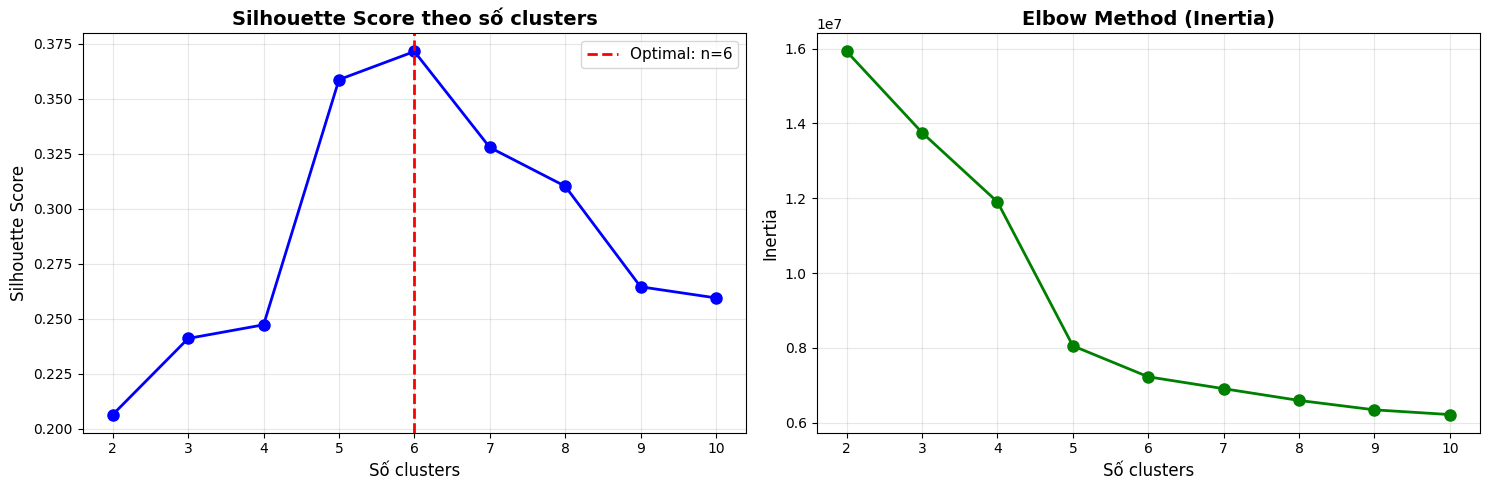


Bảng kết quả chi tiết:
------------------------------------------------------------
n_clusters      Silhouette           Inertia             
------------------------------------------------------------
2               0.2064               15924399.75         
3               0.2410               13756230.48         
4               0.2472               11903631.00         
5               0.3587               8057014.91          
6               0.3715               7229528.33           <-- TỐI ƯU
7               0.3278               6912354.14          
8               0.3102               6598008.49          
9               0.2645               6346616.30          
10              0.2594               6220348.58          
------------------------------------------------------------


In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ 1: Silhouette Score
axes[0].plot(list(n_clusters_range), silhouette_scores, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=best_n, color='red', linestyle='--', linewidth=2, label=f'Optimal: n={best_n}')
axes[0].set_xlabel('Số clusters', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score theo số clusters', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Biểu đồ 2: Elbow Method (Inertia)
axes[1].plot(list(n_clusters_range), inertias, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Số clusters', fontsize=12)
axes[1].set_ylabel('Inertia', fontsize=12)
axes[1].set_title('Elbow Method (Inertia)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bảng kết quả
print("\nBảng kết quả chi tiết:")
print("-" * 60)
print(f"{'n_clusters':<15} {'Silhouette':<20} {'Inertia':<20}")
print("-" * 60)
for n, sil, ine in zip(n_clusters_range, silhouette_scores, inertias):
    marker = " <-- TỐI ƯU" if n == best_n else ""
    print(f"{n:<15} {sil:<20.4f} {ine:<20.2f}{marker}")
print("-" * 60)

## Bước 5: Train model cuối cùng với số clusters tối ưu

Qua quá trình nhận định, dựa trên dataset thực tế + Elbow + Silhouette, nhóm quyết định thống nhất chọn k = 5.

In [59]:
print(f"Training model cuối cùng với n_clusters = 5..\n")

# Train model
final_model = KMeansPlusPlus(n_clusters=5, random_state=5)
final_labels = final_model.fit_predict(X_pca30)

# Tính metrics
final_silhouette = silhouette_score(X_pca30, final_labels)

print("\n" + "="*60)
print("KẾT QUẢ CUỐI CÙNG")
print("="*60)
print(f"Số clusters: {best_n}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Inertia: {final_model.inertia_:.2f}")
print(f"Tổng số mẫu: {len(final_labels)}")
print("\nPhân bố các clusters:")
print("-" * 40)

unique, counts = np.unique(final_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    percentage = count / len(final_labels) * 100
    print(f"Cluster {cluster}: {count:5d} samples ({percentage:5.2f}%)")
print("="*60)

Training model cuối cùng với n_clusters = 5..

K-Means++ hội tụ tại vòng lặp 11

KẾT QUẢ CUỐI CÙNG
Số clusters: 6
Silhouette Score: 0.3698
Inertia: 7953302.14
Tổng số mẫu: 801

Phân bố các clusters:
----------------------------------------
Cluster 0:   303 samples (37.83%)
Cluster 1:   136 samples (16.98%)
Cluster 2:    76 samples ( 9.49%)
Cluster 3:   145 samples (18.10%)
Cluster 4:   141 samples (17.60%)


## Bước 6: So sánh với nhãn thật (Ground Truth)

In [60]:
# Load nhãn thật
df_true_labels = pd.read_csv(DATA_PATH + 'labels.csv', index_col=0)
y_true = df_true_labels['Class'].values

# Tính toán độ chính xác so với nhãn thật
ari_score = adjusted_rand_score(y_true, final_labels)
nmi_score = normalized_mutual_info_score(y_true, final_labels)

print("="*50)
print("ĐÁNH GIÁ VỚI NHÃN THẬT (GROUND TRUTH)")
print("="*50)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print("-" * 50)

if ari_score > 0.5:
    print("Đánh giá: Kết quả phân cụm RẤT TỐT, sát với phân loại gen thực tế.")
elif ari_score > 0.3:
    print("Đánh giá: Kết quả phân cụm KHÁ TỐT.")
else:
    print("Đánh giá: Cần xem lại số lượng clusters hoặc cách xử lý dữ liệu.")

ĐÁNH GIÁ VỚI NHÃN THẬT (GROUND TRUTH)
Adjusted Rand Index (ARI): 0.9851
Normalized Mutual Information (NMI): 0.9773
--------------------------------------------------
Đánh giá: Kết quả phân cụm RẤT TỐT, sát với phân loại gen thực tế.


## Bước 7: Lưu kết quả

In [61]:
# Lưu labels
df_labels = pd.DataFrame(final_labels, index=df_pca.index, columns=['kmeans_plusplus'])
output_path = DATA_PATH + 'kmeans_plusplus_labels.csv'
df_labels.to_csv(output_path)

print(f"Đã lưu kết quả vào: {output_path}")
print(f"Shape: {df_labels.shape}")
print("\nMẫu dữ liệu:")
print(df_labels.head(10))

Đã lưu kết quả vào: /content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/kmeans_plusplus_labels.csv
Shape: (801, 1)

Mẫu dữ liệu:
          kmeans_plusplus
sample_0                1
sample_1                4
sample_2                1
sample_3                1
sample_4                0
sample_5                1
sample_6                3
sample_7                1
sample_8                0
sample_9                1


## Bước 8: Visualization - Vẽ clusters trên PC1 và PC2

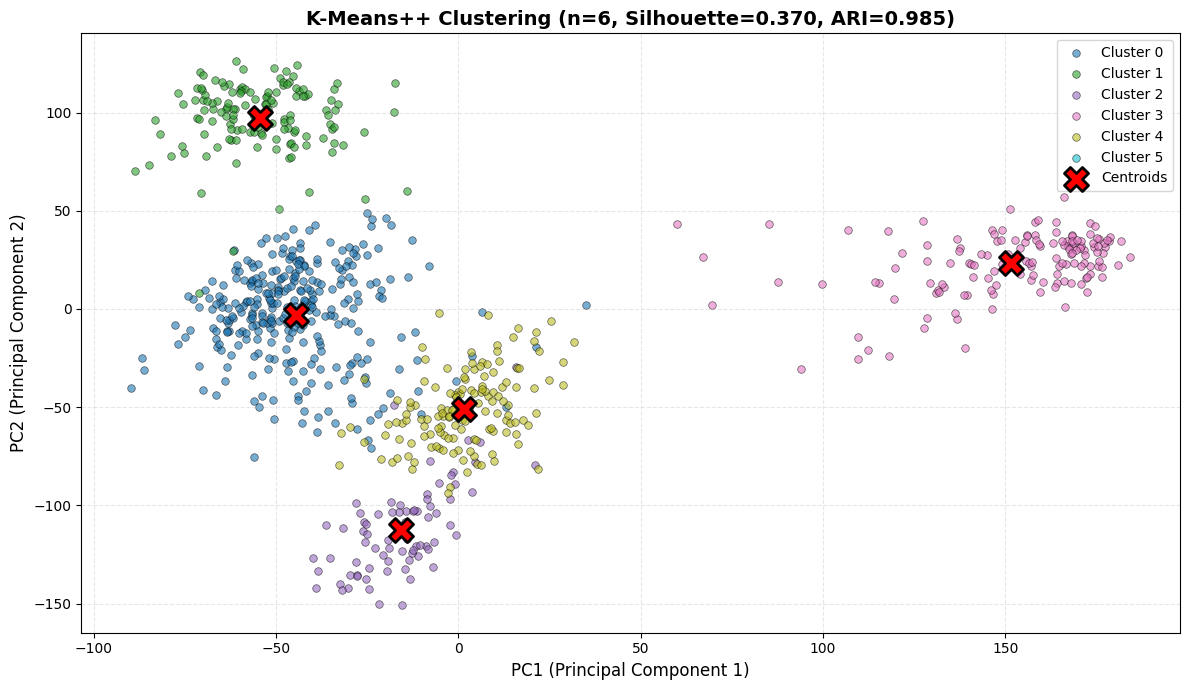

In [62]:
# Định nghĩa màu sắc cho từng cluster
colors = plt.cm.tab10(np.linspace(0, 1, best_n))

plt.figure(figsize=(12, 7))

for i in range(best_n):
    cluster_points = X_pca30[final_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=[colors[i]], label=f'Cluster {i}',
                alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Vẽ centroids
centroids = final_model.centroids
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='red', marker='X', s=300, edgecolors='black', linewidth=2,
            label='Centroids', zorder=10)

plt.xlabel('PC1 (Principal Component 1)', fontsize=12)
plt.ylabel('PC2 (Principal Component 2)', fontsize=12)
plt.title(f'K-Means++ Clustering (n={best_n}, Silhouette={final_silhouette:.3f}, ARI={ari_score:.3f})',
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## Kết luận

Đã implement thành công K-Means++ từ đầu với các bước:

1. ✅ Khởi tạo centroids thông minh theo thuật toán K-Means++
2. ✅ Thuật toán clustering với vòng lặp assign-update
3. ✅ Tìm số clusters tối ưu bằng Silhouette Score và Elbow Method
4. ✅ Đánh giá với Ground Truth (ARI, NMI)
5. ✅ Visualization kết quả với centroids
6. ✅ So sánh với K-Means thông thường

**Ưu điểm của K-Means++:**
- Khởi tạo centroids thông minh, tránh khởi tạo xấu
- Hội tụ nhanh hơn K-Means thông thường
- Kết quả ổn định hơn, ít phụ thuộc vào seed ngẫu nhiên
- Hiệu suất tốt trên dữ liệu biểu hiện gen

Code được viết hoàn toàn thủ công, không sử dụng sklearn.cluster.KMeans!